# fit_us_data.ipynb

Fit various functions to COVID-19 time series for U.S. counties using the Broyden–Fletcher–Goldfarb–Shanno solver from `sklearn.optimize`.

Inputs:
* `outputs/us_counties_clean.csv`: The contents of `data/us_counties.csv` after data cleaning by [clean_us_data.ipynb](./clean_us_data.ipynb)
* `outputs/us_counties_clean_meta.json`: Column type metadata for reading `data/us_counties_clean.csv` with `pd.read_csv()`

Outputs:
* `outputs/us_counties_curves.csv`: The curves that this notebook generated
* `outputs/us_counties_curves_meta.json`: Column type metadata for reading `data/us_counties_curves.csv` with `pd.read_csv()`
* `outputs/us_counties_curves_params.csv`: Model parameters corresponding to the curves in `data/us_counties_curves.csv`

**Note:** You can redirect these input and output files by setting the environment variable `COVID_OUTPUTS_DIR` to a replacement for the prefix `outputs` in the above paths.

In [1]:
# Initialization boilerplate
import os
import json
import pandas as pd
import numpy as np
import scipy.optimize
from sklearn import metrics
from typing import *

import text_extensions_for_pandas as tp

# Local file of utility functions
import util

# What precision of floating-point to use.
# Consider 32-bit if using GPU-accelerated solvers. Otherwise, 64-bit
# floating point is better because it reduces the chance of divergence.
fp_type = np.float64

# Allow environment variables to override data file locations.
_OUTPUTS_DIR = os.getenv("COVID_OUTPUTS_DIR", "outputs")

In [2]:
# Read in the CSV file and apply the saved type information
csv_file = os.path.join(_OUTPUTS_DIR, "us_counties_clean.csv")
meta_file = os.path.join(_OUTPUTS_DIR, "us_counties_clean_meta.json")

# Read column type metadata
with open(meta_file) as f:
    cases_meta = json.load(f)

# Pandas does not currently support parsing datetime64 from CSV files.
# As a workaround, read the "Date" column as objects and manually 
# convert after.
cases_meta["Date"] = "object"

cases_vertical = (
    pd
    .read_csv(csv_file, dtype=cases_meta, parse_dates=["Date"])   
    .set_index(["FIPS", "Date"], verify_integrity=True)
)
cases_vertical

State   County  Population  Confirmed  Deaths  Recovered  \
FIPS  Date                                                                     
1001  2020-01-22  Alabama  Autauga       55869          0       0          0   
      2020-01-23  Alabama  Autauga       55869          0       0          0   
      2020-01-24  Alabama  Autauga       55869          0       0          0   
      2020-01-25  Alabama  Autauga       55869          0       0          0   
      2020-01-26  Alabama  Autauga       55869          0       0          0   
...                   ...      ...         ...        ...     ...        ...   
56045 2020-05-13  Wyoming   Weston        6927          0       0          0   
      2020-05-14  Wyoming   Weston        6927          0       0          0   
      2020-05-15  Wyoming   Weston        6927          0       0          0   
      2020-05-16  Wyoming   Weston        6927          0       0          0   
      2020-05-17  Wyoming   Weston        6927          0       0          0   

                  Confirmed_Outlier  Deaths_Outlier  Recovered_Outlier  
FIPS  Date                                                              
1001  2020-01-22              False           False              False  
      2020-01-23              False           False              False  
      2020-01-24              False           False              False  
      2020-01-25              False           False              False  
      2020-01-26              False           False              False  
...                             ...             ...                ...  
56045 2020-05-13              False           False              False  
      2020-05-14              False           False              False  
      2020-05-15              False           False              False  
      2020-05-16              False           False              False  
      2020-05-17              False           False              False  

[367614 rows x 9 columns]

In [3]:
# As a workaround for a bug in Pandas' extension types system,
# we need to cast the boolean columns to ints.
for col in ["Confirmed_Outlier", "Deaths_Outlier", "Recovered_Outlier"]:
    cases_vertical[col] = cases_vertical[col].astype(np.int8)
cases_vertical

State   County  Population  Confirmed  Deaths  Recovered  \
FIPS  Date                                                                     
1001  2020-01-22  Alabama  Autauga       55869          0       0          0   
      2020-01-23  Alabama  Autauga       55869          0       0          0   
      2020-01-24  Alabama  Autauga       55869          0       0          0   
      2020-01-25  Alabama  Autauga       55869          0       0          0   
      2020-01-26  Alabama  Autauga       55869          0       0          0   
...                   ...      ...         ...        ...     ...        ...   
56045 2020-05-13  Wyoming   Weston        6927          0       0          0   
      2020-05-14  Wyoming   Weston        6927          0       0          0   
      2020-05-15  Wyoming   Weston        6927          0       0          0   
      2020-05-16  Wyoming   Weston        6927          0       0          0   
      2020-05-17  Wyoming   Weston        6927          0       0          0   

                  Confirmed_Outlier  Deaths_Outlier  Recovered_Outlier  
FIPS  Date                                                              
1001  2020-01-22                  0               0                  0  
      2020-01-23                  0               0                  0  
      2020-01-24                  0               0                  0  
      2020-01-25                  0               0                  0  
      2020-01-26                  0               0                  0  
...                             ...             ...                ...  
56045 2020-05-13                  0               0                  0  
      2020-05-14                  0               0                  0  
      2020-05-15                  0               0                  0  
      2020-05-16                  0               0                  0  
      2020-05-17                  0               0                  0  

[367614 rows x 9 columns]

In [4]:
# Use Text Extensions for Pandas to collapse each time series or mask down to a single cell
cases, dates = util.collapse_time_series(cases_vertical, [
    "Confirmed", "Deaths", "Recovered", 
    "Confirmed_Outlier", "Deaths_Outlier", "Recovered_Outlier"])
cases

,State,County,Population,Confirmed,Deaths,Recovered,Confirmed_Outlier,Deaths_Outlier,Recovered_Outlier
FIPS,,,,,,,,,
1001,Alabama,Autauga,55869,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1003,Alabama,Baldwin,223234,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1005,Alabama,Barbour,24686,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1007,Alabama,Bibb,22394,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1009,Alabama,Blount,57826,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
...,...,...,...,...,...,...,...,...,...
56037,Wyoming,Sweetwater,42343,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
56039,Wyoming,Teton,23464,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
56041,Wyoming,Uinta,20226,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...


In [5]:
# To simplify the code that follows, we only fit curves to one of
# the time series for each county. 
# Change the following constant to use a different time series:
ts_col_name = "Confirmed"

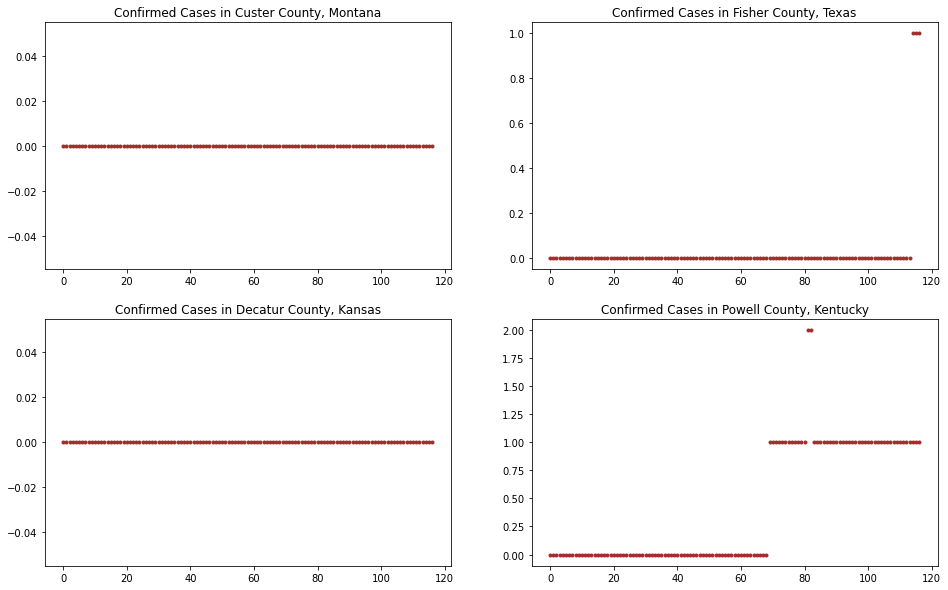

In [6]:
# Because these time series are integer-valued, there can be
# problems with aliasing. 
# Here are some examples of what aliasing looks like:
# (graph_examples() function defined in util.py)
util.graph_examples(cases, ts_col_name, {}, 
                    mask=(np.max(cases[ts_col_name].values, axis=1) < 10))

In [7]:
# To avoid problems due to aliasing, we will restrict the analysis
# in the rest of this notebook to time series whose maximum values
# go above a threshold:
alias_threshold = 100

# We also cut off the sections at the beginning of the time 
# series where every time series' value is below this threshold.

# Find what point in the time series at least one county went above
# the threshold.
first_time_above_min = np.argmax(np.max(cases[ts_col_name].values, axis=0) >= alias_threshold)
print(f"Dropping the first {first_time_above_min} elements of each time series.")

# Find which counties have at least one time series value above the 
# threshold.
counties_mask = np.max(cases[ts_col_name].values, axis=1) >= alias_threshold

# Filter rows
filtered = cases[counties_mask].copy(deep=True)

# Truncate time series to just the times when at least one county
# was above our threshold.
filtered[ts_col_name] = filtered[ts_col_name].values[:,first_time_above_min:]

# Also filter the outlier masks
outlier_col_name = ts_col_name + "_Outlier"
filtered[outlier_col_name] = filtered[outlier_col_name].values[:,first_time_above_min:]

filtered_dates = dates[first_time_above_min:]

# Drop time series columns other than the one we analyze
series_to_keep = [ts_col_name, outlier_col_name]
metadata_cols = []
to_drop = []
for colname in filtered.columns:
    if not isinstance(filtered[colname].dtype, tp.TensorType):
        metadata_cols.append(colname)
    elif colname not in series_to_keep:
        to_drop.append(colname)
        
filtered = filtered.drop(columns=to_drop)

filtered

Dropping the first 48 elements of each time series.


,State,County,Population,Confirmed,Confirmed_Outlier
FIPS,,,,,
1001,Alabama,Autauga,55869,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1003,Alabama,Baldwin,223234,[ 0 0 0 0 0 1 1 1 1 1 2 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1013,Alabama,Butler,19448,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1015,Alabama,Calhoun,113605,[ 0 0 0 0 0 0 0 0 1 1 1 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1017,Alabama,Chambers,33254,[ 0 0 0 0 0 0 0 0 0 1 2 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
...,...,...,...,...,...
55133,Wisconsin,Waukesha,404198,[ 0 0 1 1 3 3 3 4 5 12 15 2...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
55139,Wisconsin,Winnebago,171907,[ 0 0 0 0 1 1 3 3 5 5 5 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
56013,Wyoming,Fremont,39261,[ 0 0 0 0 1 1 1 8 8 8 9 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...


In [8]:
# Warm-up: Fit a straight line.
# We use sklearn's implementation of BGFS as the optimizer.

# What precision of floating-point to use
# On a laptop, there's not much reason to use 32-bit.
fp_type = np.float64
series_values = filtered[ts_col_name].values.astype(fp_type)
series_len = series_values.shape[1]
x = np.linspace(0, series_len - 1, series_len, dtype=fp_type)

def linear_curve(m, b):
    return m * x + b

def linear_objective(var_values, y):
    m, b = var_values
    return np.sum((y - (linear_curve(m, b))) ** 2)

linear_initial_guess = (0.1, 1.0)
linear_bounds = ((0.0, 1000.0), (float(-series_len), float(series_len)))

linear = filtered[metadata_cols].copy()
linear["Result_Object"] = [
    scipy.optimize.minimize(
        linear_objective, linear_initial_guess,
        args=(ts), bounds=linear_bounds)
    for ts in series_values
]
linear["Slope"] = linear["Result_Object"].apply(lambda r: r.x[0])
linear["Intercept"] = linear["Result_Object"].apply(lambda r: r.x[1])

# Generate all the linear curves
M = linear["Slope"].values.reshape([-1, 1])
X = x.reshape([1, -1])
B = linear["Intercept"].values.reshape([-1, 1])
linear["Curve"] = tp.TensorArray(M * X + B)

# Compute coefficient of determination
linear["R^2"] = [
    metrics.r2_score(
        filtered.loc[fips][ts_col_name], linear.loc[fips]["Curve"]) 
        for fips in filtered.index]

linear

,State,County,Population,Result_Object,Slope,Intercept,Curve,R^2
FIPS,,,,,,,,
1001,Alabama,Autauga,55869,"{'fun': 9787.73581780539, 'jac': [0.0001818989...",1.412422,-18.558592,[-18.5585916 -17.14616925 -15.73374691 -14.321...,0.847991
1003,Alabama,Baldwin,223234,"{'fun': 24283.275703324885, 'jac': [0.00582076...",4.216368,-48.052173,[-48.05217272 -43.83580444 -39.61943616 -35.403...,0.952466
1013,Alabama,Butler,19448,"{'fun': 161017.38024601561, 'jac': [-0.0029103...",3.213226,-59.307676,[-59.30767574 -56.09444926 -52.88122278 -49.667...,0.637028
1015,Alabama,Calhoun,113605,"{'fun': 5900.674180976751, 'jac': [0.000181898...",2.328498,-22.545755,[-22.54575489 -20.21725655 -17.88875822 -15.560...,0.961758
1017,Alabama,Chambers,33254,"{'fun': 75499.45503592775, 'jac': [0.013096723...",6.286920,-46.682817,[-46.68281742 -40.39589735 -34.10897727 -27.822...,0.934763
...,...,...,...,...,...,...,...,...
55133,Wisconsin,Waukesha,404198,"{'fun': 12548.548386314673, 'jac': [0.00109139...",7.428863,-43.436425,[-43.43642457 -36.00756117 -28.57869777 -21.149...,0.991761
55139,Wisconsin,Winnebago,171907,"{'fun': 8152.435854342024, 'jac': [0.000272848...",1.673438,-17.737470,[-17.73747009 -16.06403211 -14.39059414 -12.717...,0.903862
56013,Wyoming,Fremont,39261,"{'fun': 43098.16865181122, 'jac': [0.000727595...",3.160687,-37.419888,[-37.41988808 -34.25920094 -31.09851379 -27.937...,0.863839


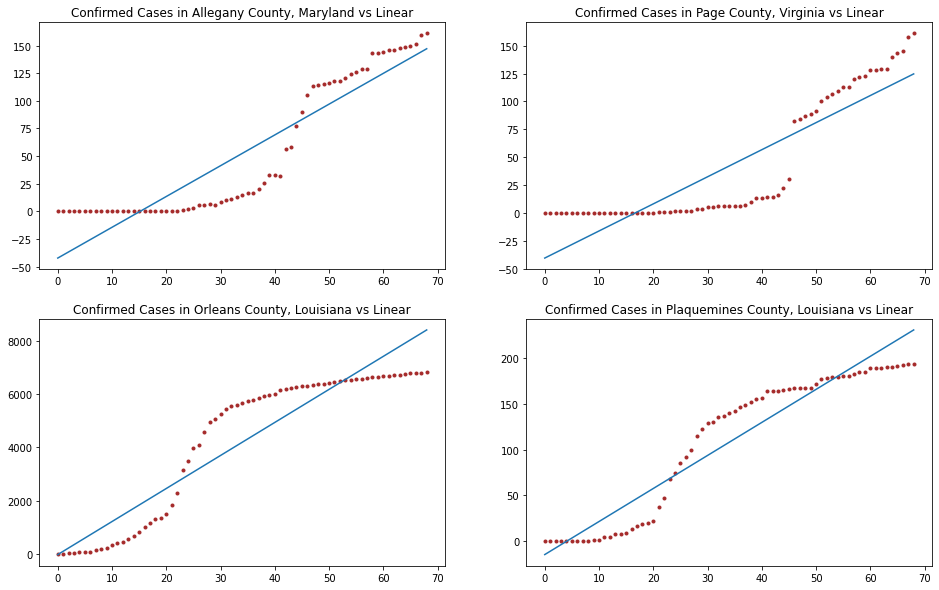

In [9]:
# Plot the lines we just fit, using the graph_examples() function in util.py.
util.graph_examples(filtered, ts_col_name, {"Linear": linear})

In [10]:
# Now let's fit some more appropriate curves to this data.
# First, break out the repetitive parts of the curve-fitting process into
# a Python function.
def curve_fit_df(df: pd.DataFrame, ts_col_name: str,
                 curve_fn,
                 param_names: Tuple,
                 initial_guess: Tuple,
                 bounds: Tuple,     
                 regularize_fn = None):
    """
    Fit a curve to a column full of time series.
    
    :param df: DataFrame containing one time series per cell
    :param ts_col_name: Column containing the time series to analyze
    :param curve_fn: Function that, if called with a vector of X values
     and a tuple of parameters, will compute the value of the curve 
     being fit.
     If parameters are vectors, this function must compute multiple
     curves, one for each element of the vectors.
    
    :param param_names: Names of the parameters of `curve_fn`.
    :param initial_guess: Initial values for the paramters to start
     off the solver.
    :param bounds: Lower and upper bounds for the parameters.
    :param regularize_fn: Optional function that returns a 
     regularization penalty, given a set of parameter values.
    
    :returns: A dataframe with one row per row of `df`, containing
     information about the 
    """
    series_values = df[ts_col_name].values.astype(fp_type)
    series_len = series_values.shape[1]
    x = np.linspace(0, series_len - 1, series_len, dtype=fp_type)
    
    def return_zero(var_values):
        return 0.0
    
    if regularize_fn is None:
        regularize_fn = return_zero
    
    def objective(var_values, y):
        squared_diffs = np.sum((y - (curve_fn(x, var_values))) ** 2)
        return squared_diffs + regularize_fn(var_values)
    
    result = pd.DataFrame(index=df.index)
    result[metadata_cols] = df[metadata_cols]
    result["Result_Object"] = [
        scipy.optimize.minimize(
            objective, initial_guess,
            args=(ts), bounds=bounds)
        for ts in series_values
    ]
    
    # Add a column for each parameter
    for i in range(len(param_names)):
        name = param_names[i]
        result[name] = result["Result_Object"].apply(lambda r: r.x[i])

    # Generate all the curves
    param_vectors = [
        result[name].values.reshape([-1, 1])
        for name in param_names
    ]
    result["Curve"] = tp.TensorArray(curve_fn(x, param_vectors))

    # Compute coefficient of determination
    result["R^2"] = [
        metrics.r2_score(
            df.loc[fips][ts_col_name], result.loc[fips]["Curve"]) 
            for fips in df.index]

    return result

In [11]:
# Define curve-fitting routines using the function from the previous
# cell.

def fit_exponential(ts_col_name: str):
    """
    Fit an exponential curve to each time series in the specified column
    of the `cases` dataframe.
    """    
    def curve_fn(x, var_values):
        rate, offset = var_values
        # Y = e^(rate)(X - offset)
        return np.exp(rate * (x - offset))
    
    param_names = ("Rate", "Offset")
    initial_guess = (0.1, 1.0)
    bounds = ((0.0, 1.0), (0.0, float(len(filtered_dates))))
    
    return curve_fit_df(filtered, ts_col_name, curve_fn,
                        param_names, initial_guess, bounds)


def fit_logistic(ts_col_name: str):
    """
    Fit a logistic curve to each time series in the specified column
    of the `cases` dataframe.
    """    
    def curve_fn(x, var_values):
        max_, rate, offset = var_values
        # Y = max / (1 + e^(-rate *(X - offset))
        return max_ / (1.0 + np.exp(-rate * (x - offset)))
    
    param_names = ("Max", "Rate", "Offset")
    initial_guess = (1000.0, 0.1, 1.0)
    bounds = ((0.0, 1e6), (0.0, 1.0), (0.0, float(len(filtered_dates))))
    
    return curve_fit_df(filtered, ts_col_name, curve_fn,
                        param_names, initial_guess, bounds)


def fit_logistic2(ts_col_name: str):
    """
    Fit a mixture of two logistic curve sto each time series in the 
    specified column of the `cases` dataframe.
    """
    # Distance from X=0 at which the logistic function is close enough to 0 or 1
    # that we can consider it to have "triggered"
    logistic2_limit = np.array(6., dtype=fp_type)
    
    def curve_fn(x, var_values):
        (max1, rate1, offset1, 
         max2, rate2, offset2, 
         switch_begin, switch_end) = var_values
        
        # logistic curve is Y = max / (1 + e^(-rate *(X - offset))
        logistic1 = max1 / (1.0 + np.exp(-rate1 * (x - offset1)))
        logistic2 = max2 / (1.0 + np.exp(-rate2 * (x - offset2)))

        # What fraction of the output comes from logistic2?
        def sigmoid(x_):
            return 1. / (1. + np.exp(-x_))
        
        mix_input = (x - switch_begin - logistic2_limit) / np.maximum(1.0, (switch_end - switch_begin))
        return logistic1 * (1.0 - sigmoid(mix_input)) + logistic2 * sigmoid(mix_input)
    
    def regularize_fn(var_values):
        (max1, rate1, offset1, 
         max2, rate2, offset2, 
         switch_begin, switch_end) = var_values
        reg_coeff = 1e7
        linear_terms = [
            max(0.0, switch_begin - switch_end - 1.0)  # switch_end >= switch_begin + 1
        ]
        return reg_coeff * sum([t for t in linear_terms])
    
    param_names = (
        "Max1", "Rate1", "Offset1",
        "Max2", "Rate2", "Offset2",
        "Switch_Begin", "Switch_End")
    initial_guess = (
        1000.0, 0.1, 1.0,  # First logistic function
        1000.0, 0.1, 1.0,  # Second logistic function
        10.0, 20.0  # Switchover
    )
    series_len = len(filtered_dates)
    bounds = (
        (0.0, 1e6), (0.0, 10.0), (0.0, float(series_len)),   # First logistic function
        (0.0, 1e6), (0.0, 10.0), (0.0, float(series_len)),   # Second logistic function
        (0.0, float(series_len)), (0.0, float(series_len))  # Switchover
    )
    
    return curve_fit_df(filtered, ts_col_name, curve_fn,
                        param_names, initial_guess, bounds,
                        regularize_fn=regularize_fn)


In [12]:
# Now we can fit those curves.
# First, the exponential curves.
exp_df = fit_exponential(ts_col_name)
exp_df

,State,County,Population,Result_Object,Rate,Offset,Curve,R^2
FIPS,,,,,,,,
1001,Alabama,Autauga,55869,"{'fun': 120292.0, 'jac': [60163.994203321636, ...",0.000000,69.0,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1...,-0.868203
1003,Alabama,Baldwin,223234,"{'fun': 1124499.0, 'jac': [224685.99490821362,...",0.000000,69.0,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1...,-1.201186
1013,Alabama,Butler,19448,"{'fun': 608885.0, 'jac': [60497.99267202616, 0...",0.000000,69.0,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1...,-0.372575
1015,Alabama,Calhoun,113605,"{'fun': 367780.0, 'jac': [141197.97269813716, ...",0.000000,69.0,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1...,-1.383566
1017,Alabama,Chambers,33254,"{'fun': 1127644.815696666, 'jac': [-0.76834112...",0.092567,0.0,[ 1. 1.09698636 1.20337908 1.320...,0.025632
...,...,...,...,...,...,...,...,...
55133,Wisconsin,Waukesha,404198,"{'fun': 1404933.1524302743, 'jac': [10.9663233...",0.096465,0.0,[ 1. 1.10127071 1.21279717 1.335...,0.077550
55139,Wisconsin,Winnebago,171907,"{'fun': 185273.0, 'jac': [92705.98529838026, 0...",0.000000,69.0,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1...,-1.184843
56013,Wyoming,Fremont,39261,"{'fun': 645446.0, 'jac': [160463.98086473346, ...",0.000000,69.0,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1...,-1.039177


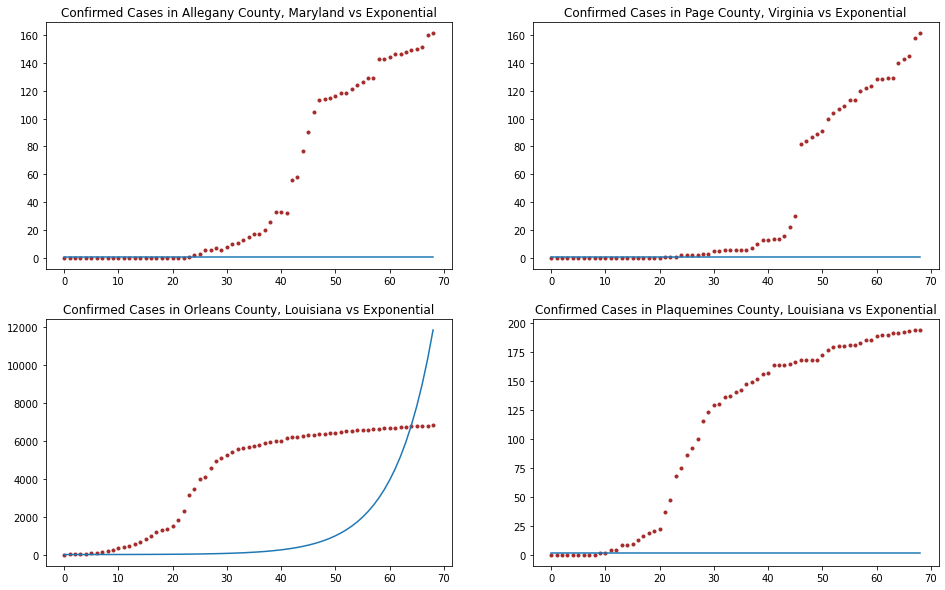

In [13]:
util.graph_examples(filtered, ts_col_name, {"Exponential": exp_df})

In [14]:
# Then fit the logistic function
log_df = fit_logistic(ts_col_name)
log_df

,State,County,Population,Result_Object,Max,Rate,Offset,Curve,R^2
FIPS,,,,,,,,,
1001,Alabama,Autauga,55869,"{'fun': 1120.7360763818122, 'jac': [6.82121026...",220.507559,0.072698,69.000000,[ 1.45236888 1.56110969 1.6779297 1.803...,0.982594
1003,Alabama,Baldwin,223234,"{'fun': 3242.66468345069, 'jac': [0.0002728484...",253.546021,0.107391,42.650713,[ 2.57287919 2.86127469 3.18158681 3.537...,0.993653
1013,Alabama,Butler,19448,"{'fun': 1002.2235094202017, 'jac': [0.00076170...",333.446715,0.178081,59.250087,[8.72249124e-03 1.04226431e-02 1.24541692e-02 1...,0.997741
1015,Alabama,Calhoun,113605,"{'fun': 3198.5785612292007, 'jac': [0.00013642...",128.728254,0.112374,37.675949,[ 1.83955484 2.05484255 2.29487023 2.562...,0.979270
1017,Alabama,Chambers,33254,"{'fun': 5904.371293544457, 'jac': [-0.00090949...",311.776092,0.176634,31.194822,[ 1.2563206 1.49786823 1.78559018 2.128...,0.994898
...,...,...,...,...,...,...,...,...,...
55133,Wisconsin,Waukesha,404198,"{'fun': 24447.530507882264, 'jac': [0.00145519...",456.757453,0.086515,36.690306,[ 18.33674957 19.92153259 21.63652355 23.491...,0.983948
55139,Wisconsin,Winnebago,171907,"{'fun': 1120.8009751589568, 'jac': [-6.8212102...",249.030866,0.060721,69.000000,[ 3.71663238 3.9456146 4.18846356 4.445...,0.986783
56013,Wyoming,Fremont,39261,"{'fun': 3252.604543311751, 'jac': [0.000227373...",413.991045,0.071534,64.638514,[ 4.02380176 4.3190724 4.63576529 4.975...,0.989724


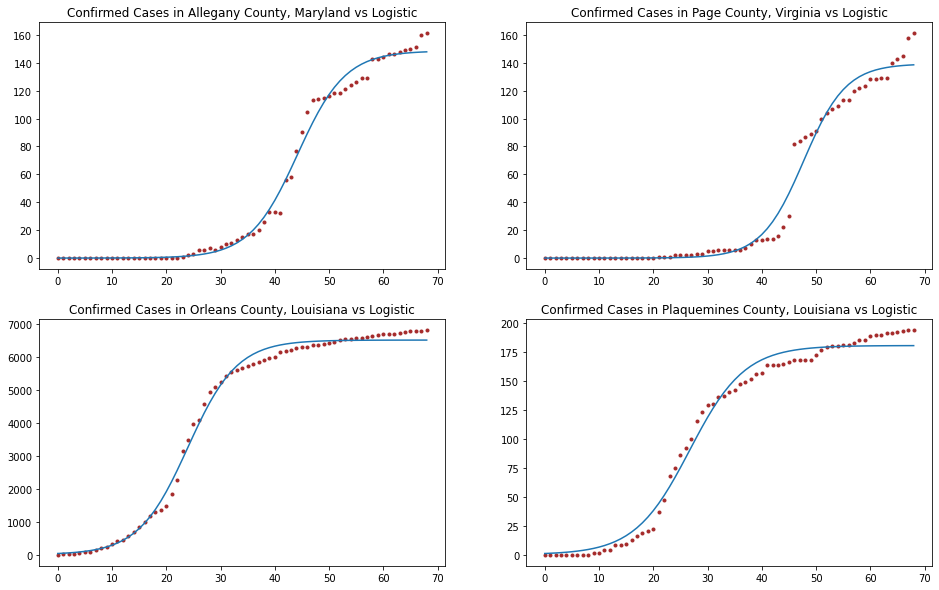

In [15]:
util.graph_examples(filtered, ts_col_name, {"Logistic": log_df})

In [16]:
# And finally a mixture of two copies of the logistic function
log2_df = fit_logistic2(ts_col_name)
log2_df

,State,County,Population,Result_Object,Max1,Rate1,Offset1,Max2,Rate2,Offset2,Switch_Begin,Switch_End,Curve,R^2
FIPS,,,,,,,,,,,,,,
1001,Alabama,Autauga,55869,"{'fun': 103.09367966627978, 'jac': [-4.9737991...",1419.349992,0.348968,65.279688,53.714540,3.236958,14.382468,33.278405,43.598479,[1.77447803e-07 2.50995262e-07 3.54948362e-07 5...,0.998399
1003,Alabama,Baldwin,223234,"{'fun': 474.161936528702, 'jac': [-0.046082959...",535.638267,0.695515,45.357924,519.301303,0.040293,69.000000,21.466305,27.074776,[2.24782961e-01 2.78630288e-01 3.45248445e-01 4...,0.999072
1013,Alabama,Butler,19448,"{'fun': 936.4052334299788, 'jac': [0.007139533...",323.151902,0.119303,58.410333,324.666982,0.187087,58.923584,9.651052,20.775420,[2.45092359e-01 2.71296116e-01 2.99929789e-01 3...,0.997889
1015,Alabama,Calhoun,113605,"{'fun': 1763.2077124518307, 'jac': [-0.0253521...",132.831373,0.429680,31.692333,129.950014,0.100274,37.259914,16.734170,15.736972,[1.61907557e-04 2.48814446e-04 3.82370951e-04 5...,0.988572
1017,Alabama,Chambers,33254,"{'fun': 1591.2480200914388, 'jac': [0.03351487...",56.398120,8.364028,29.968907,447.777401,0.020263,17.395100,23.179009,28.260747,[ 0.59115411 0.72779069 0.89578444 1.102...,0.998625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55133,Wisconsin,Waukesha,404198,"{'fun': 1876.3339325386778, 'jac': [0.00109139...",932.476564,0.351420,64.329276,940.493799,0.032788,69.000000,12.643473,17.395936,[ 1.7202925 2.17717658 2.75229679 3.474...,0.998768
55139,Wisconsin,Winnebago,171907,"{'fun': 1094.4836088777304, 'jac': [0.0, 0.000...",511.082241,8.922810,68.373833,293.599386,0.053269,69.000000,0.000001,37.173960,[ 3.33516736 3.56400346 3.80758097 4.066...,0.987093
56013,Wyoming,Fremont,39261,"{'fun': 3337.1254430272625, 'jac': [0.00027284...",566.841775,10.000000,69.000000,571.117421,0.066692,63.593953,0.000000,69.000000,[ 3.87501415 4.16950833 4.48585047 4.825...,0.989457


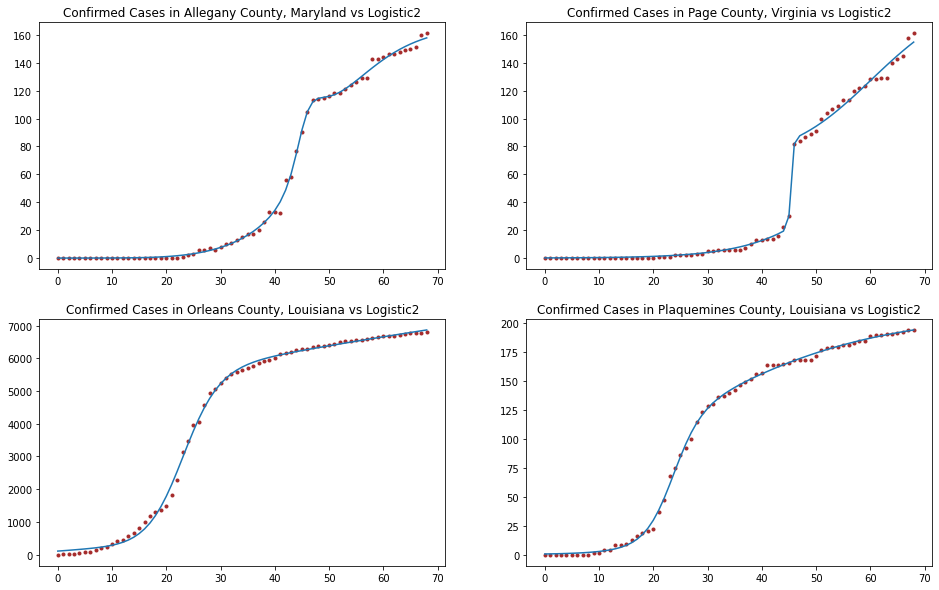

In [17]:
util.graph_examples(filtered, ts_col_name, {"Logistic2": log2_df})

In [18]:
# Stuff all the curves that we have fit into a single dataframe,
# along with the original series' values
curves_df = filtered[metadata_cols + [ts_col_name, outlier_col_name]].copy()
curves_df["Exponential"] = exp_df["Curve"]
curves_df["Logistic"] = log_df["Curve"]
curves_df["Logistic2"] = log2_df["Curve"]
curves_df

,State,County,Population,Confirmed,Confirmed_Outlier,Exponential,Logistic,Logistic2
FIPS,,,,,,,,
1001,Alabama,Autauga,55869,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1...,[ 1.45236888 1.56110969 1.6779297 1.803...,[1.77447803e-07 2.50995262e-07 3.54948362e-07 5...
1003,Alabama,Baldwin,223234,[ 0 0 0 0 0 1 1 1 1 1 2 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1...,[ 2.57287919 2.86127469 3.18158681 3.537...,[2.24782961e-01 2.78630288e-01 3.45248445e-01 4...
1013,Alabama,Butler,19448,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1...,[8.72249124e-03 1.04226431e-02 1.24541692e-02 1...,[2.45092359e-01 2.71296116e-01 2.99929789e-01 3...
1015,Alabama,Calhoun,113605,[ 0 0 0 0 0 0 0 0 1 1 1 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1...,[ 1.83955484 2.05484255 2.29487023 2.562...,[1.61907557e-04 2.48814446e-04 3.82370951e-04 5...
1017,Alabama,Chambers,33254,[ 0 0 0 0 0 0 0 0 0 1 2 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.09698636 1.20337908 1.320...,[ 1.2563206 1.49786823 1.78559018 2.128...,[ 0.59115411 0.72779069 0.89578444 1.102...
...,...,...,...,...,...,...,...,...
55133,Wisconsin,Waukesha,404198,[ 0 0 1 1 3 3 3 4 5 12 15 2...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.10127071 1.21279717 1.335...,[ 18.33674957 19.92153259 21.63652355 23.491...,[ 1.7202925 2.17717658 2.75229679 3.474...
55139,Wisconsin,Winnebago,171907,[ 0 0 0 0 1 1 3 3 5 5 5 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1...,[ 3.71663238 3.9456146 4.18846356 4.445...,[ 3.33516736 3.56400346 3.80758097 4.066...
56013,Wyoming,Fremont,39261,[ 0 0 0 0 1 1 1 8 8 8 9 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1...,[ 4.02380176 4.3190724 4.63576529 4.975...,[ 3.87501415 4.16950833 4.48585047 4.825...


In [19]:
# Expand out the tensors to multiple rows for writing to a CSV file, and
# cast the boolean values back to np.bool
curves_vertical = util.explode_time_series(curves_df, filtered_dates)
curves_vertical["Confirmed_Outlier"] = curves_vertical["Confirmed_Outlier"].astype(np.bool)
curves_vertical

State   County  Population  Confirmed  Confirmed_Outlier  \
FIPS  Date                                                                     
1001  2020-03-10  Alabama  Autauga       55869          0              False   
      2020-03-11  Alabama  Autauga       55869          0              False   
      2020-03-12  Alabama  Autauga       55869          0              False   
      2020-03-13  Alabama  Autauga       55869          0              False   
      2020-03-14  Alabama  Autauga       55869          0              False   
...                   ...      ...         ...        ...                ...   
56039 2020-05-13  Wyoming    Teton       23464         99              False   
      2020-05-14  Wyoming    Teton       23464         99              False   
      2020-05-15  Wyoming    Teton       23464         99              False   
      2020-05-16  Wyoming    Teton       23464        100              False   
      2020-05-17  Wyoming    Teton       23464        100              False   

                  Exponential    Logistic     Logistic2  
FIPS  Date                                               
1001  2020-03-10          1.0    1.452369  1.774478e-07  
      2020-03-11          1.0    1.561110  2.509953e-07  
      2020-03-12          1.0    1.677930  3.549484e-07  
      2020-03-13          1.0    1.803420  5.018344e-07  
      2020-03-14          1.0    1.938211  7.093184e-07  
...                       ...         ...           ...  
56039 2020-05-13          1.0  100.341289  9.734251e+01  
      2020-05-14          1.0  100.505990  9.734144e+01  
      2020-05-15          1.0  100.650322  9.734072e+01  
      2020-05-16          1.0  100.776758  9.734024e+01  
      2020-05-17          1.0  100.887478  9.733992e+01  

[63135 rows x 8 columns]

In [20]:
# Write out the results to a CSV file plus a JSON file of type metadata.
counties_curves_csv_data_file = os.path.join(_OUTPUTS_DIR, "us_counties_curves.csv")
curves_vertical.to_csv(counties_curves_csv_data_file, index=True)
col_type_mapping = {
    key: str(value) for key, value in curves_vertical.dtypes.iteritems()
}

counties_curves_json_data_file = os.path.join(_OUTPUTS_DIR, "us_counties_curves_meta.json")
print(f"Writing curves to {counties_curves_json_data_file}")
with open(counties_curves_json_data_file, "w") as f:
    json.dump(col_type_mapping, f)

Writing curves to outputs/us_counties_curves_meta.json


In [21]:
# Combine all of the parameters of the curve into another dataframe and
# write that dataframe to a second CSV file.
params = filtered[metadata_cols].copy()
params["Exp_Rate"] = exp_df["Rate"]
params["Exp_Offset"] = exp_df["Offset"]

params["Log_Max"] = log_df["Max"]
params["Log_Rate"] = log_df["Rate"]
params["Log_Offset"] = log_df["Offset"]

params["Log2_Max1"] = log2_df["Max1"]
params["Log2_Rate1"] = log2_df["Rate1"]
params["Log2_Offset1"] = log2_df["Offset1"]
params["Log2_Max2"] = log2_df["Max2"]
params["Log2_Rate2"] = log2_df["Rate2"]
params["Log2_Offset2"] = log2_df["Offset2"]
params["Log2_Switch_Begin"] = log2_df["Switch_Begin"]
params["Log2_Switch_End"] = log2_df["Switch_End"]
params

,State,County,Population,Exp_Rate,Exp_Offset,Log_Max,Log_Rate,Log_Offset,Log2_Max1,Log2_Rate1,Log2_Offset1,Log2_Max2,Log2_Rate2,Log2_Offset2,Log2_Switch_Begin,Log2_Switch_End
FIPS,,,,,,,,,,,,,,,,
1001,Alabama,Autauga,55869,0.000000,69.0,220.507559,0.072698,69.000000,1419.349992,0.348968,65.279688,53.714540,3.236958,14.382468,33.278405,43.598479
1003,Alabama,Baldwin,223234,0.000000,69.0,253.546021,0.107391,42.650713,535.638267,0.695515,45.357924,519.301303,0.040293,69.000000,21.466305,27.074776
1013,Alabama,Butler,19448,0.000000,69.0,333.446715,0.178081,59.250087,323.151902,0.119303,58.410333,324.666982,0.187087,58.923584,9.651052,20.775420
1015,Alabama,Calhoun,113605,0.000000,69.0,128.728254,0.112374,37.675949,132.831373,0.429680,31.692333,129.950014,0.100274,37.259914,16.734170,15.736972
1017,Alabama,Chambers,33254,0.092567,0.0,311.776092,0.176634,31.194822,56.398120,8.364028,29.968907,447.777401,0.020263,17.395100,23.179009,28.260747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55133,Wisconsin,Waukesha,404198,0.096465,0.0,456.757453,0.086515,36.690306,932.476564,0.351420,64.329276,940.493799,0.032788,69.000000,12.643473,17.395936
55139,Wisconsin,Winnebago,171907,0.000000,69.0,249.030866,0.060721,69.000000,511.082241,8.922810,68.373833,293.599386,0.053269,69.000000,0.000001,37.173960
56013,Wyoming,Fremont,39261,0.000000,69.0,413.991045,0.071534,64.638514,566.841775,10.000000,69.000000,571.117421,0.066692,63.593953,0.000000,69.000000


In [22]:
counties_curves_params_csv_data_file = os.path.join(_OUTPUTS_DIR, "us_counties_curves_params.csv")
print(f"Writing parameters of curves to {counties_curves_params_csv_data_file}.")
params.to_csv(counties_curves_params_csv_data_file, index=True)

Writing parameters of curves to outputs/us_counties_curves_params.csv.
